In [1]:
import pandas as pd
import numpy as np 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
nltk.download(['punkt', 'wordnet'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

# imported the file which contains top 25 headlines, stock went up or down(label) and date
data = pd.read_csv('Combined_News_DJIA.csv')
data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [2]:
# check for the columns & rows 
data.shape

(1989, 27)

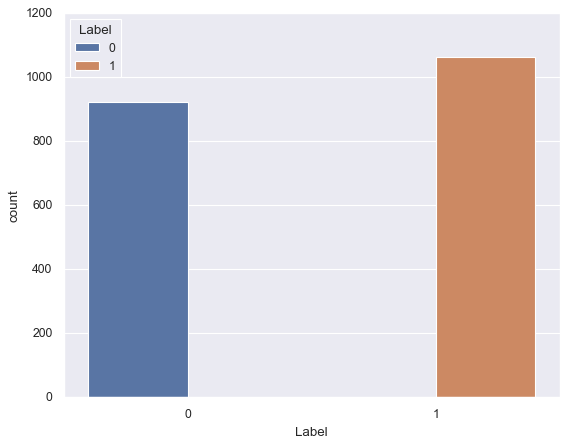

In [3]:
plt.style.use('classic')

sns.set()

ax = sns.countplot(x='Label', hue='Label', data=data)

In [4]:
data.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [5]:
# filling the null values with median 

data['Top23'].fillna(data['Top23'].median,inplace=True)
data['Top24'].fillna(data['Top24'].median,inplace=True)
data['Top25'].fillna(data['Top25'].median,inplace=True)

In [6]:
# check for NaN values
data.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    0
Top24    0
Top25    0
dtype: int64

In [7]:
# create_df function convert top 25 news columns into one column of headlines on each day. 
def create_df(dataset):
    
    dataset = dataset.drop(columns=['Date', 'Label'])
    dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)
    for col in dataset.columns:
        dataset[col] = dataset[col].str.lower()
        
    headlines = []
    for row in range(0, len(dataset.index)):
        headlines.append(' '.join(str(x) for x in dataset.iloc[row, 0:25]))
        
    df = pd.DataFrame(headlines, columns=['headlines'])
    df['label'] = data.Label
    df['date'] = data.Date
    
    return df

In [8]:
df = create_df(data)
df.head()

,headlines,label,date
0,b georgia downs two russian warplanes as cou...,0,2008-08-08
1,b why wont america and nato help us if they w...,1,2008-08-11
2,b remember that adorable year old who sang a...,0,2008-08-12
3,b u s refuses israel weapons to attack iran ...,0,2008-08-13
4,b all the experts admit that we should legalis...,1,2008-08-14


In [9]:
X = df.headlines

In [10]:
X

0       b georgia  downs two russian warplanes  as cou...
1       b why wont america and nato help us  if they w...
2       b remember that adorable   year old who sang a...
3       b  u s  refuses israel weapons to attack iran ...
4       b all the experts admit that we should legalis...
                              ...                        
1984    barclays and rbs shares suspended from trading...
1985          scientists to australia  if you want to ...
1986    explosion at airport in istanbul yemeni former...
1987    jamaica proposes marijuana dispensers for tour...
1988    a     year old woman in mexico city finally re...
Name: headlines, Length: 1989, dtype: object

In [11]:
# tokenize into list of words
def tokenize(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)

    return clean_tokens

In [12]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
# example for tokenize test  
# example for tokenize test 
for message in X[:1]:
    print(message)
    print(tokenize(message))

b georgia  downs two russian warplanes  as countries move to brink of war  b breaking  musharraf to be impeached   b russia today  columns of troops roll into south ossetia  footage from fighting  youtube   b russian tanks are moving towards the capital of south ossetia  which has reportedly been completely destroyed by georgian artillery fire  b afghan children raped with  impunity   u n  official says   this is sick  a three year old was raped and they do nothing  b     russian tanks have entered south ossetia whilst georgia shoots down two russian jets   b breaking  georgia invades south ossetia  russia warned it would intervene on so s side  b the  enemy combatent  trials are nothing but a sham  salim haman has been sentenced to       years  but will be kept longer anyway just because they feel like it   b georgian troops retreat from s  osettain capital  presumably leaving several hundred people killed   video   b did the u s  prep georgia for war with russia   b rice gives green 

In [14]:
df.head()

,headlines,label,date
0,b georgia downs two russian warplanes as cou...,0,2008-08-08
1,b why wont america and nato help us if they w...,1,2008-08-11
2,b remember that adorable year old who sang a...,0,2008-08-12
3,b u s refuses israel weapons to attack iran ...,0,2008-08-13
4,b all the experts admit that we should legalis...,1,2008-08-14


In [15]:
train = df[df['date'] < '20150101']
test = df[df['date'] > '20141231']

In [16]:
x_train = train.headlines
y_train = train.label
x_test = test.headlines
y_test = test.label

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [18]:
vectorizer_x = TfidfVectorizer()
X_train = vectorizer_x.fit_transform(x_train).toarray()
X_test = vectorizer_x.transform(x_test).toarray()

In [19]:
LDA = LinearDiscriminantAnalysis()
X_train_new = LDA.fit(X_train,y_train)
X_train_new =  LDA.transform(X_train)
X_test_new = LDA.transform(X_test)

In [20]:
from sklearn.naive_bayes import GaussianNB  
classifier = GaussianNB()  
classifier.fit(X_train_new, y_train)

GaussianNB()

In [22]:
from sklearn.metrics import confusion_matrix,accuracy_score
y_rfc=classifier.predict(X_test_new)
print(confusion_matrix(y_test,y_rfc))
print(accuracy_score(y_test,y_rfc))
print(classification_report(y_test,y_rfc))

[[ 86 100]
 [ 36 156]]
0.6402116402116402
              precision    recall  f1-score   support

           0       0.70      0.46      0.56       186
           1       0.61      0.81      0.70       192

    accuracy                           0.64       378
   macro avg       0.66      0.64      0.63       378
weighted avg       0.66      0.64      0.63       378

